Project:
If we decrease the school's funding, by how much does their ability to understand Math, English, Science, and History decrease?

# Grabbing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame

import math

plt.style.use('bmh')

%matplotlib inline

Read in the states.csv and clean it up

The states csv file has some data that we can not use. Specifically, the test scores we have only goes from 2005 through 2015, while the states funding file goes from 1992 through 2016. As such we need to remove the rows where we do not have test score data. This is done because with out those test scores, the funding information doesnt really help us.

With this done, we can move on to clearing out the columns that we do not need. We only really need the state, year, enrollment, and total expenditure (total_expenditure as that was what was spent in total for the students). The state and year columns will be used to match rows to the test scores file. The enrollment and total expenditure will be used to determine what was spent on each student, while the total expediture will be used on its own to know the total amount spent in the state for that year.

In [2]:
# states csv
statesdf = pd.read_csv("states.csv")

statesdf2 = statesdf[(statesdf['YEAR'] > 2004) & (statesdf['YEAR'] < 2016)]
stateInfo = statesdf2[['STATE', 'YEAR', 'ENROLL', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]
stateInfo

,STATE,YEAR,ENROLL,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
663,Alabama,2005,729342.0,5904664,3053380,1744013,462605.0,511944
664,Alaska,2005,132568.0,1751718,829666,559084,55782.0,268700
665,Arizona,2005,919875.0,7136794,3423716,2264931,351097.0,861286
666,Arkansas,2005,461667.0,3999608,2118580,1173643,200865.0,393713
667,California,2005,6307022.0,66196072,31070450,18046385,3132465.0,10223657
...,...,...,...,...,...,...,...,...
1219,Virginia,2015,1279867.0,16113212,8755896,5075509,627473.0,1086722
1220,Washington,2015,1072359.0,13630138,6508964,4510672,546926.0,1601069
1221,West Virginia,2015,279565.0,3466981,1819903,1161944,233836.0,232738
1222,Wisconsin,2015,861813.0,11553677,5723474,3691809,513402.0,894823


Read in the school_scores.csv and clean it up

For this file we are able to keep all of the rows, as the data is from the years that we need. Since the states.csv grabbed all of the years that we have data for in the school_scores.csv, do not need to remove any rows that we have in our csv file.

That being said, we will need to remove some columns. To start with we will need to keep the columns for year, and state name as they contain the information that will be used to undrstand which scores go to which information about the funding from the other table. At this point we need to understand what it is that we are trying to figure out. We want to figure out by how much does a students ability to understand a subject decrease when the school loses access to funding. So that means that we want to track the students GPA for that subject as the SAT scores do not have enough information that we can use. The GPA scores on the other hand, track the average GPA for their specific topic ONLY. This means we can track each subject across the years indivdualy which is what we want.

In [3]:
# school scores csv
scoresdf = pd.read_csv("school_scores.csv")

scoresInfo = scoresdf[['Year', 'State.Name', 'Academic Subjects.English.Average GPA', 'Academic Subjects.Mathematics.Average GPA', 'Academic Subjects.Natural Sciences.Average GPA', 'Academic Subjects.Social Sciences/History.Average GPA']]
scoresInfo

,Year,State.Name,Academic Subjects.English.Average GPA,Academic Subjects.Mathematics.Average GPA,Academic Subjects.Natural Sciences.Average GPA,Academic Subjects.Social Sciences/History.Average GPA
0,2005,Alabama,3.53,3.41,3.52,3.59
1,2005,Alaska,3.35,3.06,3.25,3.39
2,2005,Arizona,3.45,3.25,3.43,3.55
3,2005,Arkansas,3.61,3.46,3.55,3.67
4,2005,California,3.32,3.05,3.20,3.38
...,...,...,...,...,...,...
572,2015,Virginia,3.47,3.17,3.38,3.46
573,2015,Washington,3.50,3.22,3.37,3.48
574,2015,West Virginia,3.71,3.47,3.58,3.70
575,2015,Wisconsin,3.77,3.64,3.70,3.76


# Cleaning the Data

At this point we have all the information that we are going to use, and now we can do some preliminary tests of the data. We should do some basic tests to make sure that there are no null data points in either dataframe, and we should determine if we have the same number of states for each year in each dataframe. If there are some states without information then we will need to figure out what we should do with those states.

In [4]:
print(f"There are {stateInfo.isnull().sum().sum()} null values in the stateInfo dataframe")

print(f'There are {scoresInfo.isnull().sum().sum()} null values in the scoresInfo dataframe')

There are 0 null values in the stateInfo dataframe
There are 0 null values in the scoresInfo dataframe


We can see that there are no null values in either dataframe. That is a good thing, as it means that we will have data for everything that exists in the data frames. But we need to check if we have the same amount of data for each state.

In [5]:
print("Year and number of entries per year for stateInfo dataframe.")
print(stateInfo['YEAR'].value_counts())

print("\n\n")

print('Year and number of entries per year for scoresInfo dataframe.')
print(scoresInfo['Year'].value_counts())

Year and number of entries per year for stateInfo dataframe.
2005    51
2006    51
2007    51
2008    51
2009    51
2010    51
2011    51
2012    51
2013    51
2014    51
2015    51
Name: YEAR, dtype: int64



Year and number of entries per year for scoresInfo dataframe.
2007    53
2008    53
2011    53
2012    53
2013    53
2014    53
2015    53
2005    52
2006    52
2009    51
2010    51
Name: Year, dtype: int64


As you can see above, the scores dataframe has some extra entries per year for some of the years which is not helpful. Below is us trying to understand what the scoresInfo also has. To do this we will count the number of times that each state appears in each list. (will need to remove Vigin Islands, Puerto Rico from scores)

In [6]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
          'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
          'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 
          'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
          'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
for i in range(len(states)):
    states[i] = states[i].lower()

    
stateStates = [0 for i in range(51)]
non_states = []
for row in stateInfo.itertuples():
    state = row[1].lower()
    if state in states:
        index = states.index(state)
        stateStates[index] += 1
    else:
        non_states.append(state)
        
        
for i in range(51):
    print(f"{states[i]} {stateStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 11
wisconsin 11
wyoming 11
The non states are: []


In [7]:
scoreStates = [0 for i in range(51)]
non_states = []
for row in scoresInfo.itertuples():
    state = row[2].lower()
    if state in states:
        index = states.index(state)
        scoreStates[index] += 1
    else:
        non_states.append(state)
for i in range(51):
    print(f"{states[i]} {scoreStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 9
wisconsin 11
wyoming 11
The non states are: ['puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands']


As we can see from the above tests, the scores dataframe contains information for Puerto Rico and the Virgin Islands. Neither or these territories has data in the states dataframe, as they are not considered states. Since we have no information about funding for these places we can not use them and so it makes sense to remove them from the scores data frame. Beyond that though, the only difference is West Virgina. West Virgina has information about funding for all of the possible years, but they only have some score values for those years. Since we do not have appropriate funding for some of the years, it makes sense to remove West Virgina from the data frame. 

While it would be nice to use add the information on Puerto Rico, Virgin Islands, and West Virgina to what we are going to be finding, since we do not have any information about the funding for Puerto Rico and the Virgin Islands, we can not determine how much funding played a role in the scores. Since we only have a couple scores for West Virgina, it means that we have some random funding for West Virgina without and test scores. This does not help us as we need those scores to help determine what the funding did. As such we can remove all three places from our data frames.

In [8]:
scoresInfo = scoresInfo[scoresInfo['State.Name']!='Puerto Rico']
scoresInfo = scoresInfo[scoresInfo['State.Name']!= 'Virgin Islands']
scoresInfo = scoresInfo[scoresInfo['State.Name']!= 'West Virginia']

stateInfo = stateInfo[stateInfo['STATE'] != 'West Virginia']

Testing to make sure that our data lines up again we run the code that was used to see how many states we had:

In [9]:
stateStates = [0 for i in range(51)]
non_states = []
for row in stateInfo.itertuples():
    state = row[1].lower()
    if state in states:
        index = states.index(state)
        stateStates[index] += 1
    else:
        non_states.append(state)
        
        
for i in range(51):
    print(f"{states[i]} {stateStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 0
wisconsin 11
wyoming 11
The non states are: []


In [10]:
scoreStates = [0 for i in range(51)]
non_states = []
for row in scoresInfo.itertuples():
    state = row[2].lower()
    if state in states:
        index = states.index(state)
        scoreStates[index] += 1
    else:
        non_states.append(state)
for i in range(51):
    print(f"{states[i]} {scoreStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 0
wisconsin 11
wyoming 11
The non states are: []


As we can see above, both dataframes now have the same number of data points per state and the scores data no longer contains infromation about places which we do not have information on. Now we can do some preliminary exploration of the data

# Examining the Data

As of this point in our analysis, we just know that for each state we have the same amount of data for testing and funding data. We currently dont know anything else. So to start, lets see what we can find out about the funding data.  

In [11]:
stateInfo.describe()

,YEAR,ENROLL,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
count,550.000000,5.500000e+02,5.500000e+02,5.500000e+02,5.500000e+02,5.500000e+02,5.500000e+02
mean,2010.000000,9.605022e+05,1.183577e+07,6.116815e+06,3.477265e+06,5.248746e+05,1.127240e+06
std,3.165156,1.126036e+06,1.433384e+07,7.536191e+06,3.996081e+06,6.203469e+05,1.584653e+06
min,2005.000000,4.386600e+04,8.053620e+05,3.306980e+05,2.584040e+05,2.965700e+04,2.007000e+04
25%,2007.000000,2.668488e+05,2.859536e+06,1.496336e+06,8.742602e+05,1.299215e+05,2.894152e+05
50%,2010.000000,6.713005e+05,7.412832e+06,3.692502e+06,2.268656e+06,3.758420e+05,6.719355e+05
75%,2013.000000,1.035614e+06,1.353143e+07,7.432736e+06,3.988448e+06,6.143168e+05,1.151459e+06
max,2015.000000,6.307022e+06,7.836596e+07,4.195426e+07,2.350185e+07,3.759373e+06,1.022366e+07


While this may not seem like it is all that helpful it is needed because we do not have enough information from each state (11 data points per state) so we need to look at the bigger picture. This allows to have more data points as well and is what we should be doing because we are trying to look at the overall funding to GPA instead of any individual state.

In [12]:
scoresInfo.describe()

,Year,Academic Subjects.English.Average GPA,Academic Subjects.Mathematics.Average GPA,Academic Subjects.Natural Sciences.Average GPA,Academic Subjects.Social Sciences/History.Average GPA
count,550.000000,550.000000,550.000000,550.000000,550.00000
mean,2010.000000,3.503418,3.313327,3.421636,3.52580
std,3.165156,0.181873,0.212677,0.194540,0.17213
min,2005.000000,3.030000,2.890000,2.980000,3.07000
25%,2007.000000,3.352500,3.120000,3.252500,3.38000
50%,2010.000000,3.510000,3.285000,3.415000,3.53000
75%,2013.000000,3.670000,3.517500,3.607500,3.68000
max,2015.000000,3.880000,3.760000,3.820000,3.88000


Looking at the scores info, we can see that there are some differences in GPAs. This means that the scores change over time, and so this can allow use to try and understand if funding plays any part in this. 

Before we can start graphing this, we need to combine the two dataframes so that the scores and expenditures line up with each other appropriatly.

In [13]:
stateInfo.rename(columns = {'YEAR':'Year'}, inplace = True)   # rename columns to match each other
stateInfo.rename(columns = {'STATE':'State'}, inplace = True)
stateInfo = stateInfo[['Year', 'State','ENROLL', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]   # reorder columns to match order

# rename row elements to match the other dataframe
stateInfo.loc[stateInfo['State'] == 'District Of Columbia', 'State'] = 'District of Columbia'  

scoresInfo.rename(columns = {'State.Name':'State'}, inplace = True)
scoresInfo.loc[scoresInfo['State'] == 'District Of Columbia', 'State'] = 'District of Columbia'

print(f"State info:\n {stateInfo.head()}")
print(f"Scores info:\n {scoresInfo.head()}")

stateScoresInfo = pd.merge(stateInfo, scoresInfo, on = ['Year','State'], how = 'outer')   # merge the two dataframes
stateScoresInfo.head()    # print out the head

State info:
      Year       State     ENROLL  TOTAL_EXPENDITURE  INSTRUCTION_EXPENDITURE  \
663  2005     Alabama   729342.0            5904664                  3053380   
664  2005      Alaska   132568.0            1751718                   829666   
665  2005     Arizona   919875.0            7136794                  3423716   
666  2005    Arkansas   461667.0            3999608                  2118580   
667  2005  California  6307022.0           66196072                 31070450   

     SUPPORT_SERVICES_EXPENDITURE  OTHER_EXPENDITURE  \
663                       1744013           462605.0   
664                        559084            55782.0   
665                       2264931           351097.0   
666                       1173643           200865.0   
667                      18046385          3132465.0   

     CAPITAL_OUTLAY_EXPENDITURE  
663                      511944  
664                      268700  
665                      861286  
666                      393713  

/tmp/ipykernel_3398714/1995979693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stateInfo.rename(columns = {'YEAR':'Year'}, inplace = True)   # rename columns to match each other
/tmp/ipykernel_3398714/1995979693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stateInfo.rename(columns = {'STATE':'State'}, inplace = True)


,Year,State,ENROLL,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,Academic Subjects.English.Average GPA,Academic Subjects.Mathematics.Average GPA,Academic Subjects.Natural Sciences.Average GPA,Academic Subjects.Social Sciences/History.Average GPA
0,2005,Alabama,729342.0,5904664,3053380,1744013,462605.0,511944,3.53,3.41,3.52,3.59
1,2005,Alaska,132568.0,1751718,829666,559084,55782.0,268700,3.35,3.06,3.25,3.39
2,2005,Arizona,919875.0,7136794,3423716,2264931,351097.0,861286,3.45,3.25,3.43,3.55
3,2005,Arkansas,461667.0,3999608,2118580,1173643,200865.0,393713,3.61,3.46,3.55,3.67
4,2005,California,6307022.0,66196072,31070450,18046385,3132465.0,10223657,3.32,3.05,3.20,3.38


As we can see above, each row in the new dataframe matches each the combined row from the two other tables. Now that we know that each funding information matches each score information, we can start to make our pre-visualizations. The first thing we need to do is to seperate the information that we need.

In [14]:
tot = stateScoresInfo['TOTAL_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['TOTAL_EXPENDITURE'] = tot

In [15]:
tot = stateScoresInfo['INSTRUCTION_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['INSTRUCTION_EXPENDITURE'] = tot

In [16]:
tot = stateScoresInfo['SUPPORT_SERVICES_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['SUPPORT_SERVICES_EXPENDITURE'] = tot

In [17]:
tot = stateScoresInfo['OTHER_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['OTHER_EXPENDITURE'] = tot

In [18]:
tot = stateScoresInfo['CAPITAL_OUTLAY_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['CAPITAL_OUTLAY_EXPENDITURE'] = tot

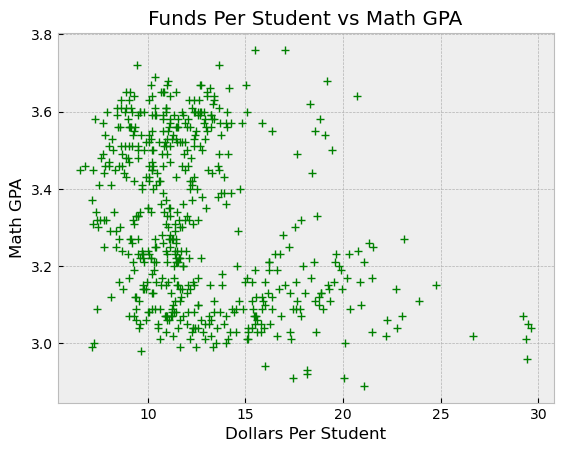

In [19]:
plt.plot(stateScoresInfo['TOTAL_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.title("Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

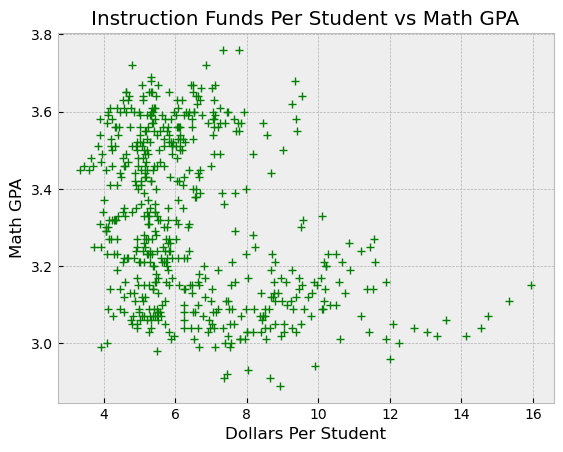

In [20]:
plt.plot(stateScoresInfo['INSTRUCTION_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.title("Instruction Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

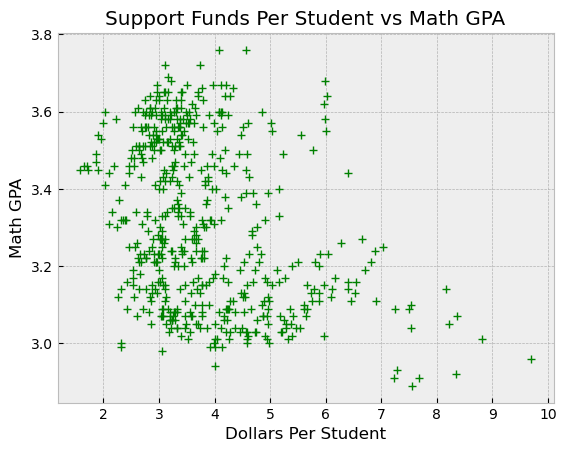

In [21]:
plt.plot(stateScoresInfo['SUPPORT_SERVICES_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.title("Support Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

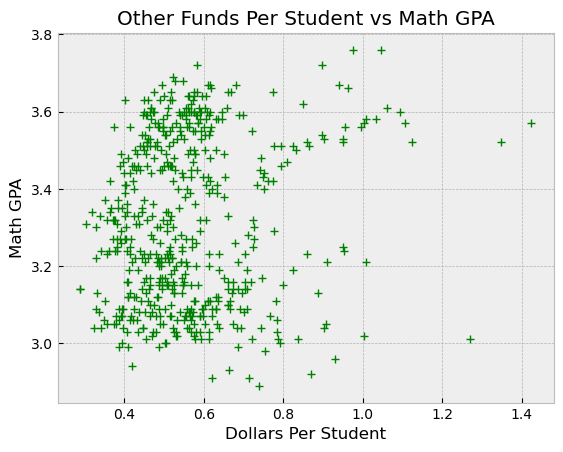

In [22]:
plt.plot(stateScoresInfo['OTHER_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.title("Other Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

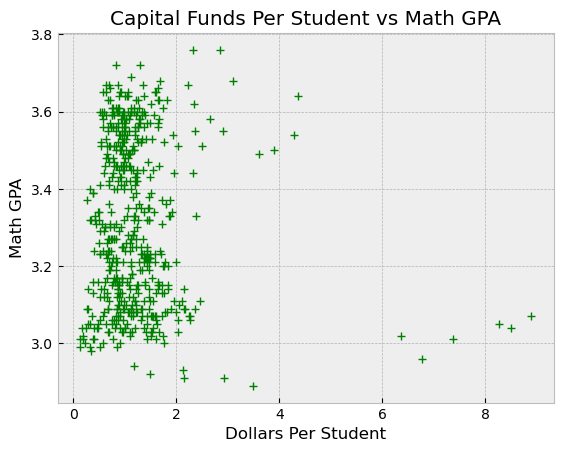

In [23]:
plt.plot(stateScoresInfo['CAPITAL_OUTLAY_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.title("Capital Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

## Modeling the Data

Now that we have the data in a form that we can used, it is time to start modeling it. So to start, we need to understand what we are doing. We are not trying to predict any labels on the data because all the data is of the same label. Instead we are trying to predict a number based on other inputs so we are going to perform some regression on this data.

Before we can do that though, we need to seperate out the data into inputs and outputs. First we should seperate the expenditure columns into its own data set and then keep the individual targets as their own data sets as well. This way when we try to model the inputs to the outputs, we can do it based on the output we are trying to find.

In [24]:
X = stateScoresInfo[['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']]

# SORT THE X_S by add to arrays. Then add to the appropriate stuff

total = stateScoresInfo['TOTAL_EXPENDITURE']
inst = stateScoresInfo['INSTRUCTION_EXPENDITURE']
supp = stateScoresInfo['SUPPORT_SERVICES_EXPENDITURE']
other = stateScoresInfo['OTHER_EXPENDITURE']
cap = stateScoresInfo['CAPITAL_OUTLAY_EXPENDITURE']

math = stateScoresInfo['Academic Subjects.Mathematics.Average GPA']
eng = stateScoresInfo['Academic Subjects.English.Average GPA']
sci = stateScoresInfo['Academic Subjects.Natural Sciences.Average GPA']
hist = stateScoresInfo['Academic Subjects.Social Sciences/History.Average GPA']

tot_x = []
ins_x = []
sup_x = []
oth_x = []
cap_x = []

for i in range(len(X)):
    line1 = []
    line1.append(total[i])
    tot_x.append(line1)
    
    line2 = []
    line2.append(inst[i])
    ins_x.append(line2)
    
    line3 = []
    line3.append(supp[i])
    sup_x.append(line3)
    
    line4 = []
    line4.append(other[i])
    oth_x.append(line4)
    
    line5 = []
    line5.append(cap[i])
    cap_x.append(line5)

    

As we can see above, we have split the data into the input and output columns that we want. With this we can start choosing the regression model that we want to use.

First, we can not use a linear model. Since the data is not linear for any of the possible inputs to outputs, we can not really use a linear regression model for this data. So instead we will need a non-linear model. That means we need to use one of the following:
    <br><br>SVR(kernal = 'rbf')
    <br>SVR(kernal = 'poly')
    <br>Info on the models: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

Below are the different figures of the two different models:

Model RBF:

In [25]:
model = svm.SVR(kernel = 'rbf')
ind_x = [tot_x, ins_x, sup_x, oth_x, cap_x]
fit_x = [total, inst, supp, other, cap]
names = ['TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']

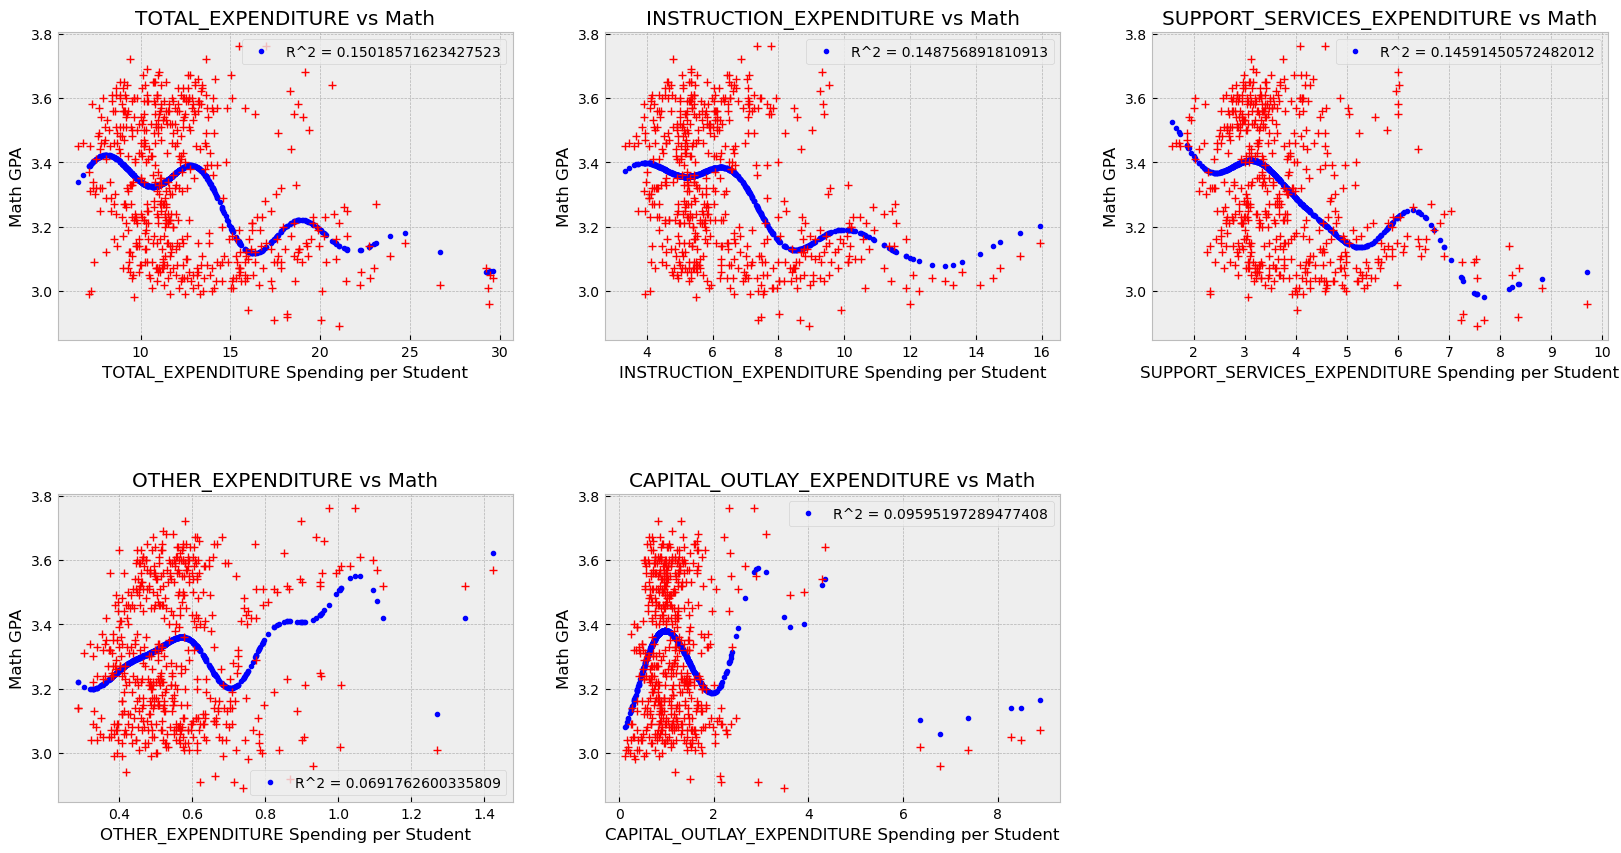

In [26]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)

for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs Math")
    plt.ylabel("Math GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model.fit(ind_x[i-1], math).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], math, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(math, model.fit(ind_x[i-1], math).predict(ind_x[i-1]) )}"])

    

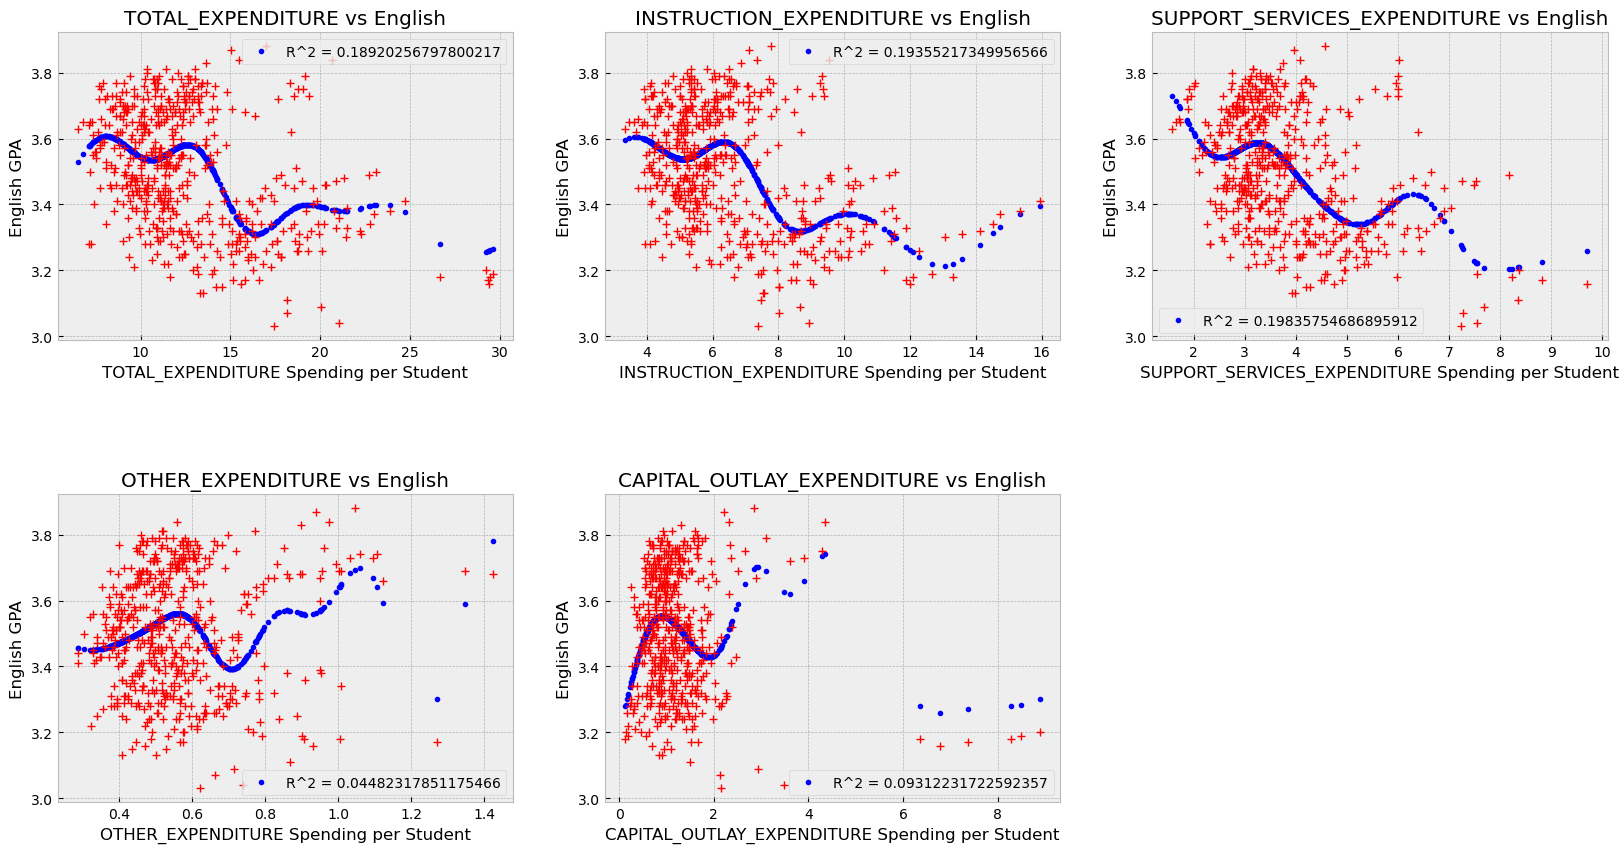

In [59]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)

for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs English")
    plt.ylabel("English GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model.fit(ind_x[i-1], eng).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], eng, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(eng, model.fit(ind_x[i-1], eng).predict(ind_x[i-1]) )}"])

    

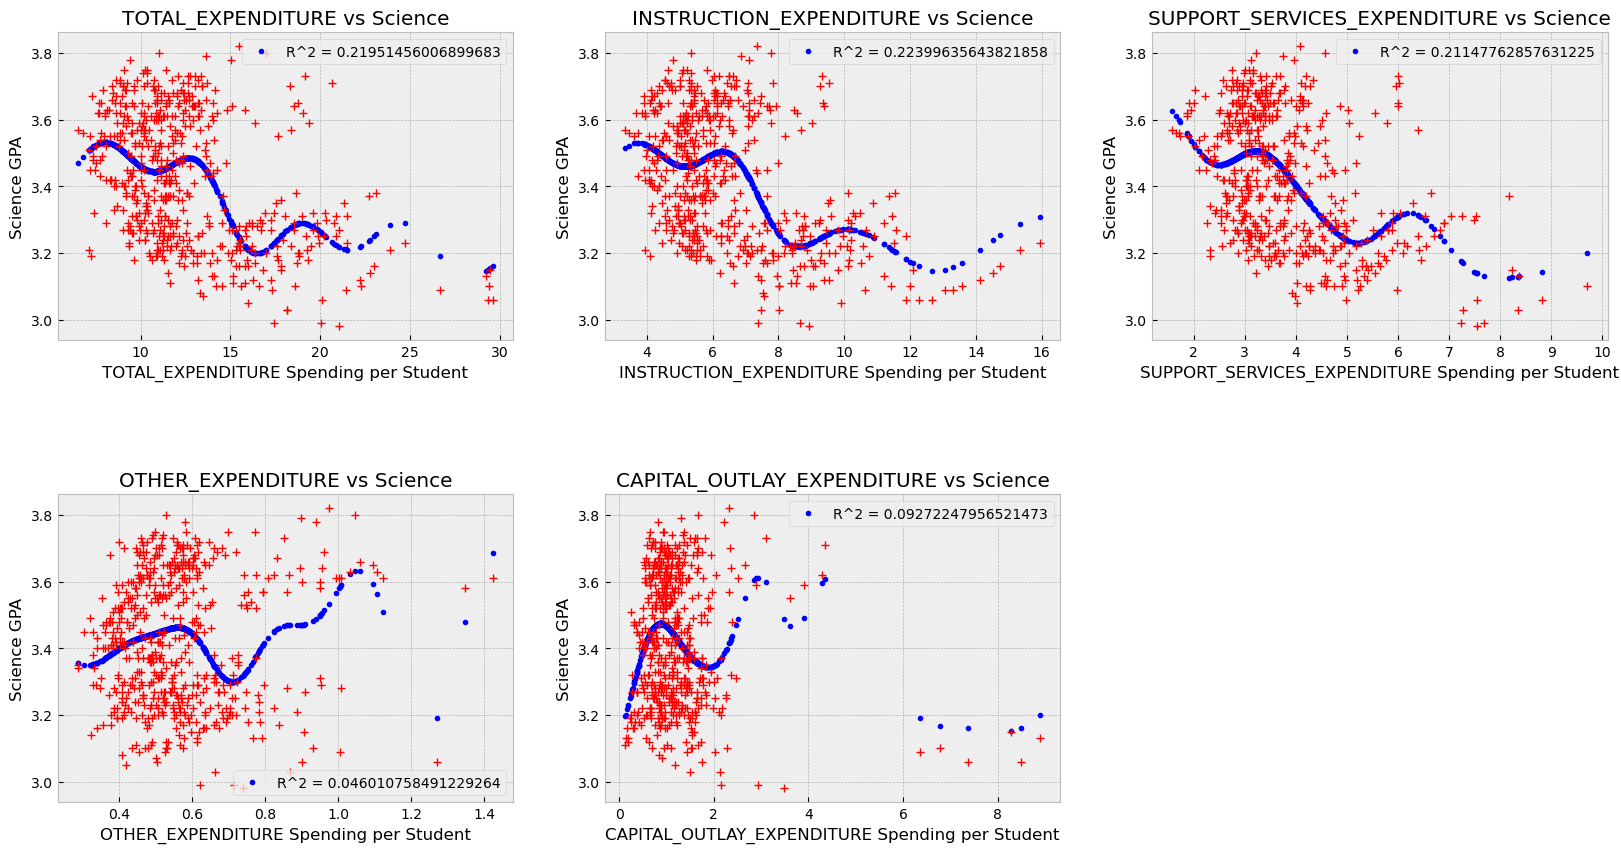

In [60]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)

for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs Science")
    plt.ylabel("Science GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model.fit(ind_x[i-1], sci).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], sci, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(sci, model.fit(ind_x[i-1], sci).predict(ind_x[i-1]) )}"])

    

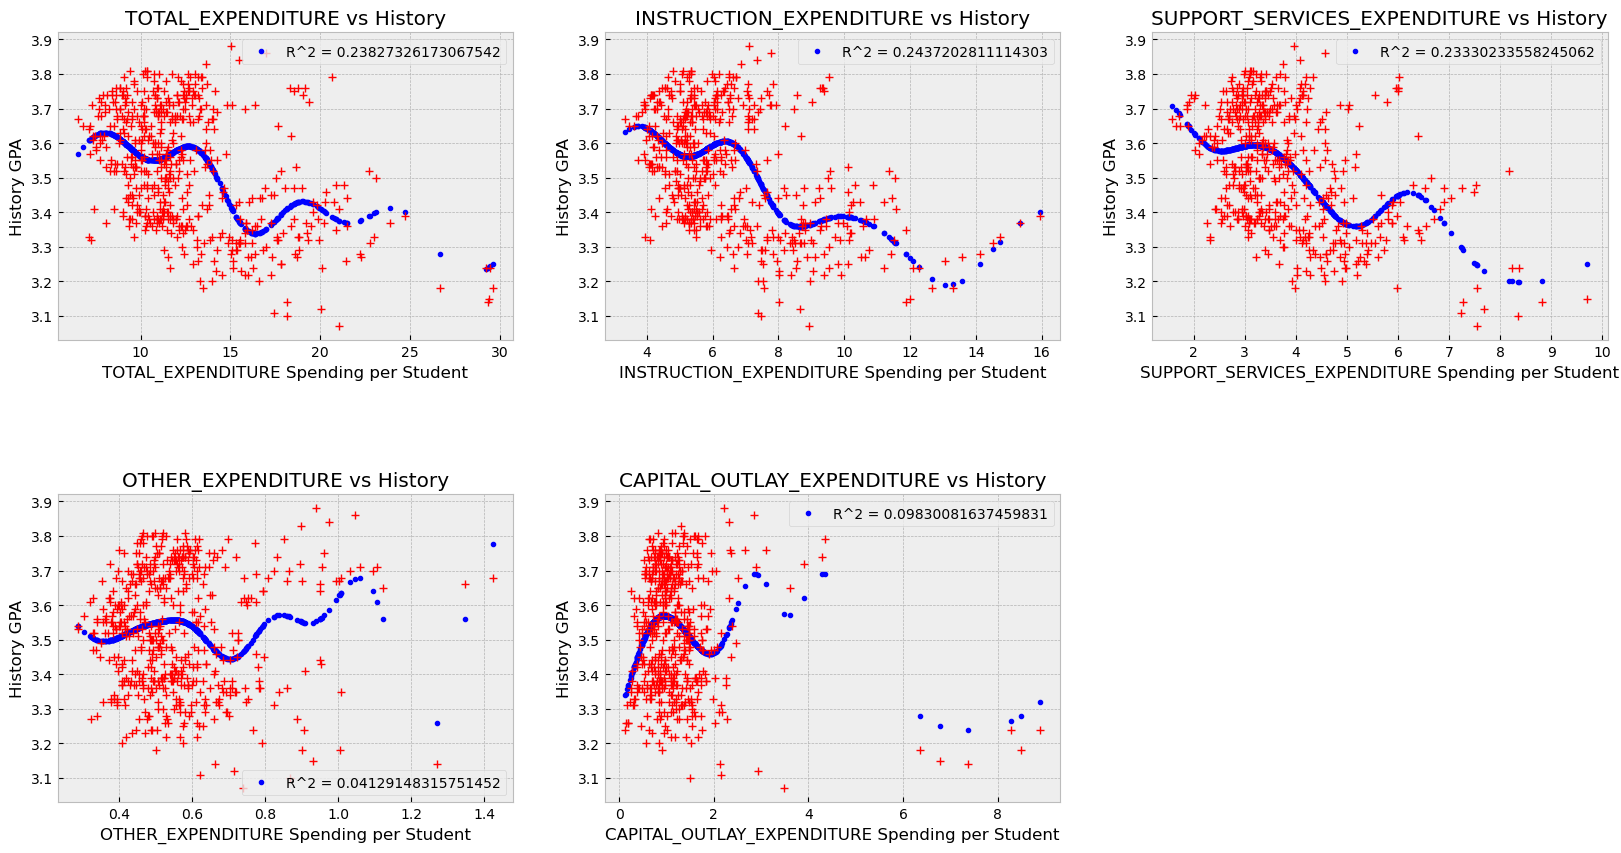

In [61]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)

for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs History")
    plt.ylabel("History GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model.fit(ind_x[i-1], hist).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], hist, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(hist, model.fit(ind_x[i-1], hist).predict(ind_x[i-1]) )}"])

    

In [31]:
model2 = svm.SVR(kernel = 'poly', degree =3)

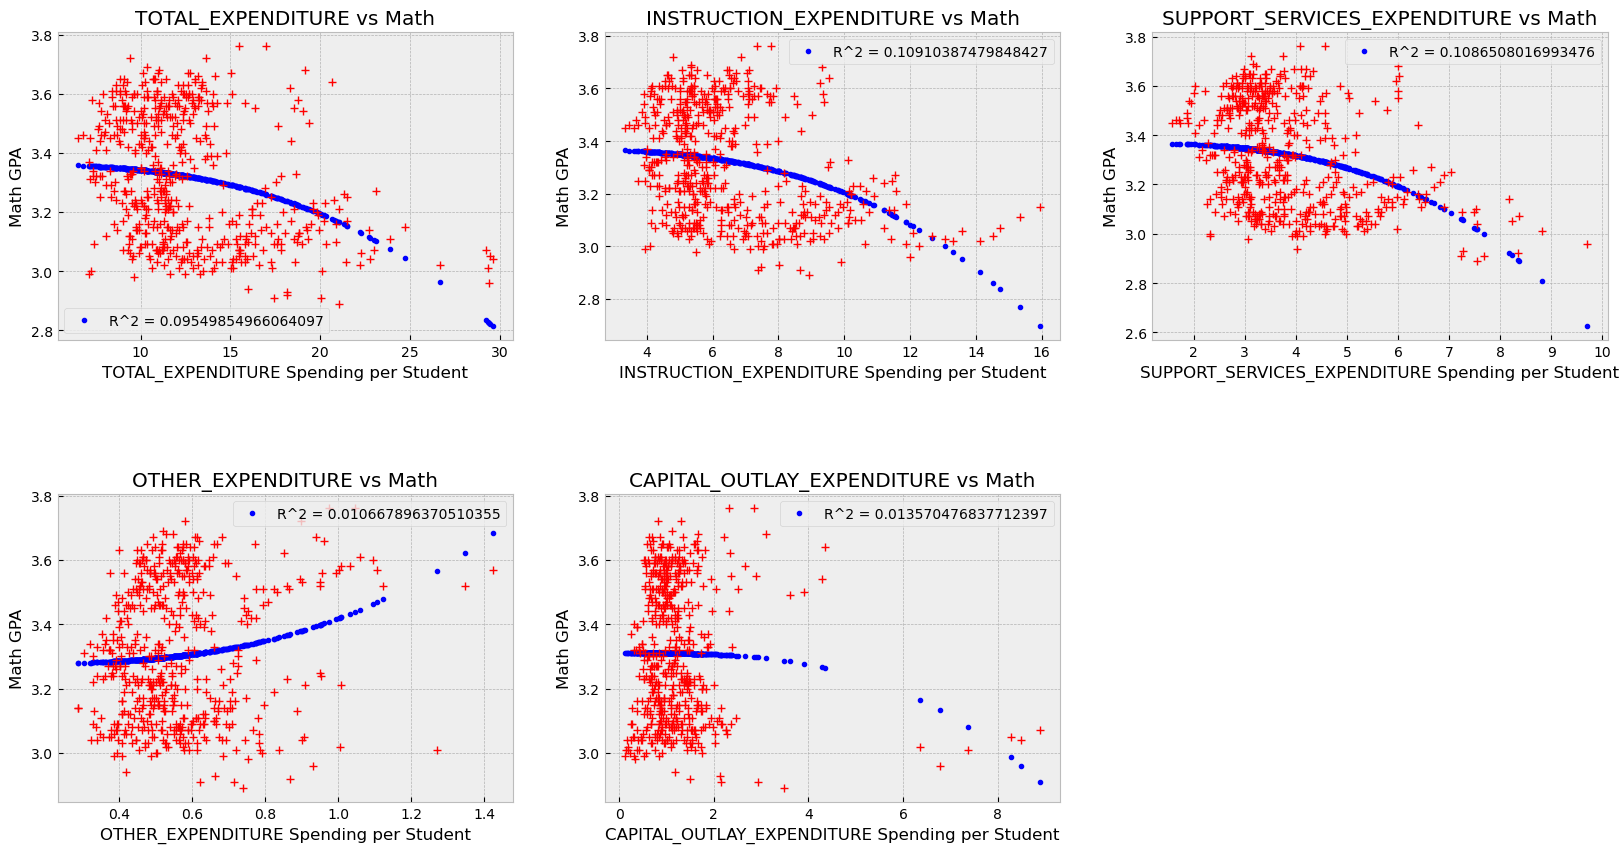

In [32]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)
for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs Math")
    plt.ylabel("Math GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model2.fit(ind_x[i-1], math).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], math, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(math, model2.fit(ind_x[i-1], math).predict(ind_x[i-1]) )}"])

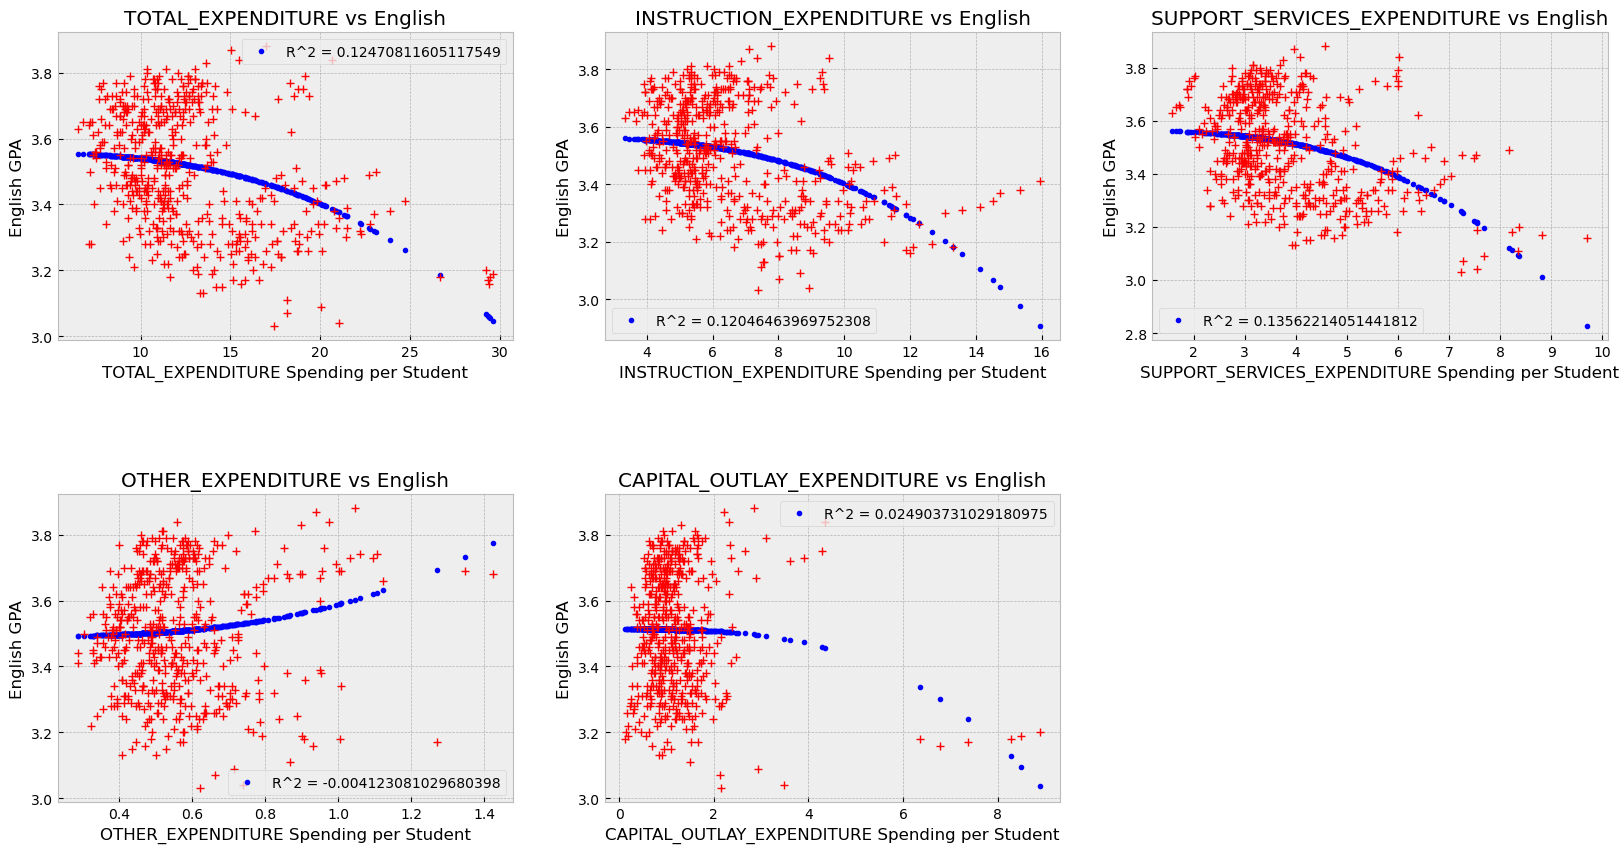

In [56]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)
for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs English")
    plt.ylabel("English GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model2.fit(ind_x[i-1], eng).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], eng, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(eng, model2.fit(ind_x[i-1], eng).predict(ind_x[i-1]) )}"])

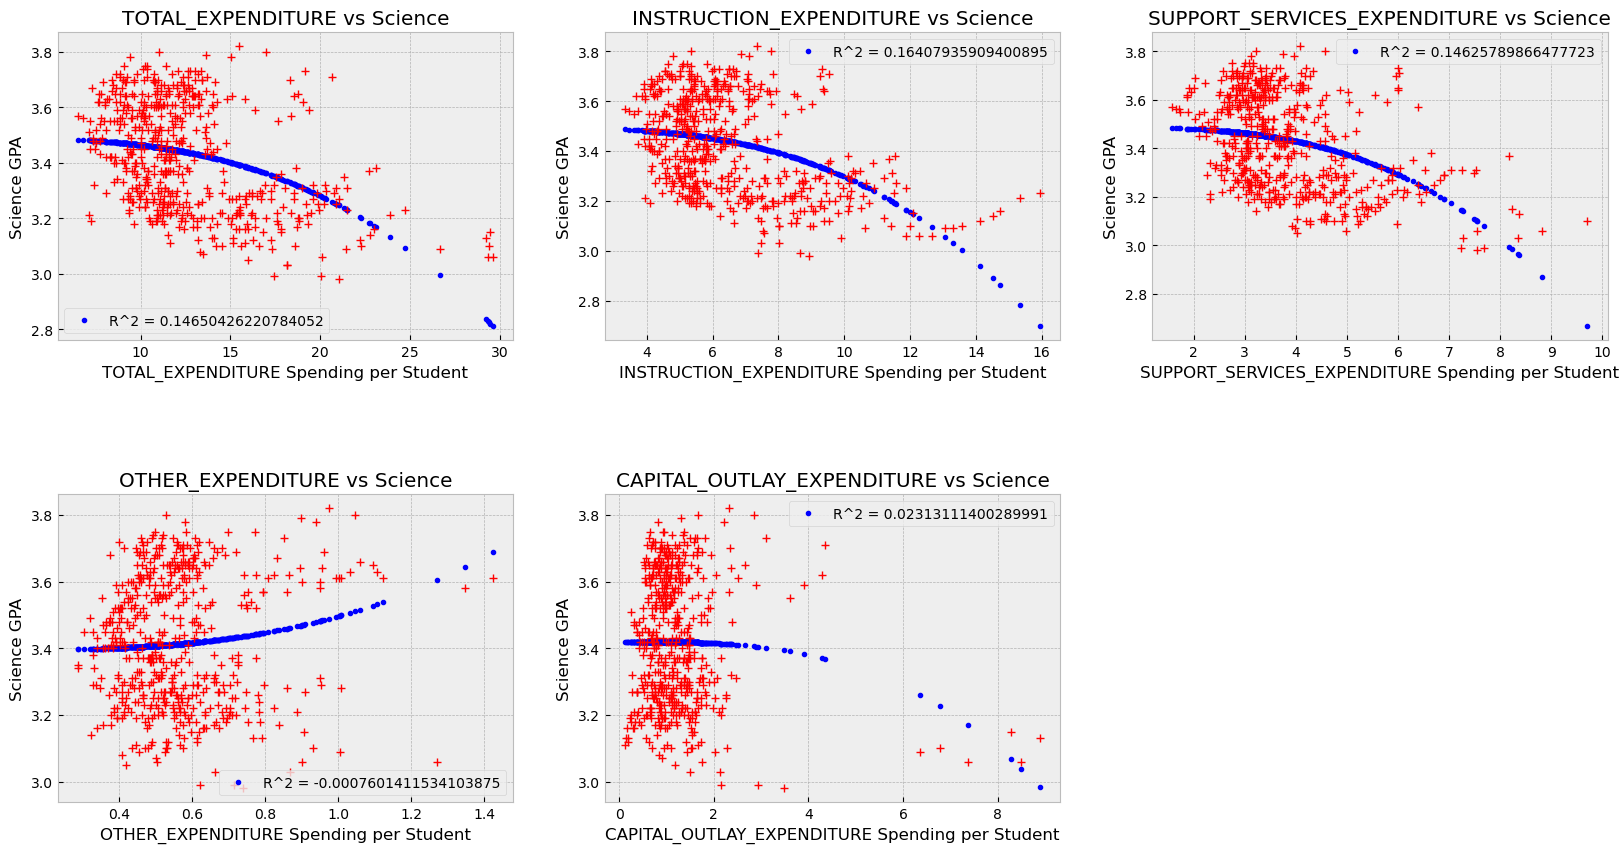

In [57]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)
for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs Science")
    plt.ylabel("Science GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model2.fit(ind_x[i-1], sci).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], sci, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(sci, model2.fit(ind_x[i-1], sci).predict(ind_x[i-1]) )}"])

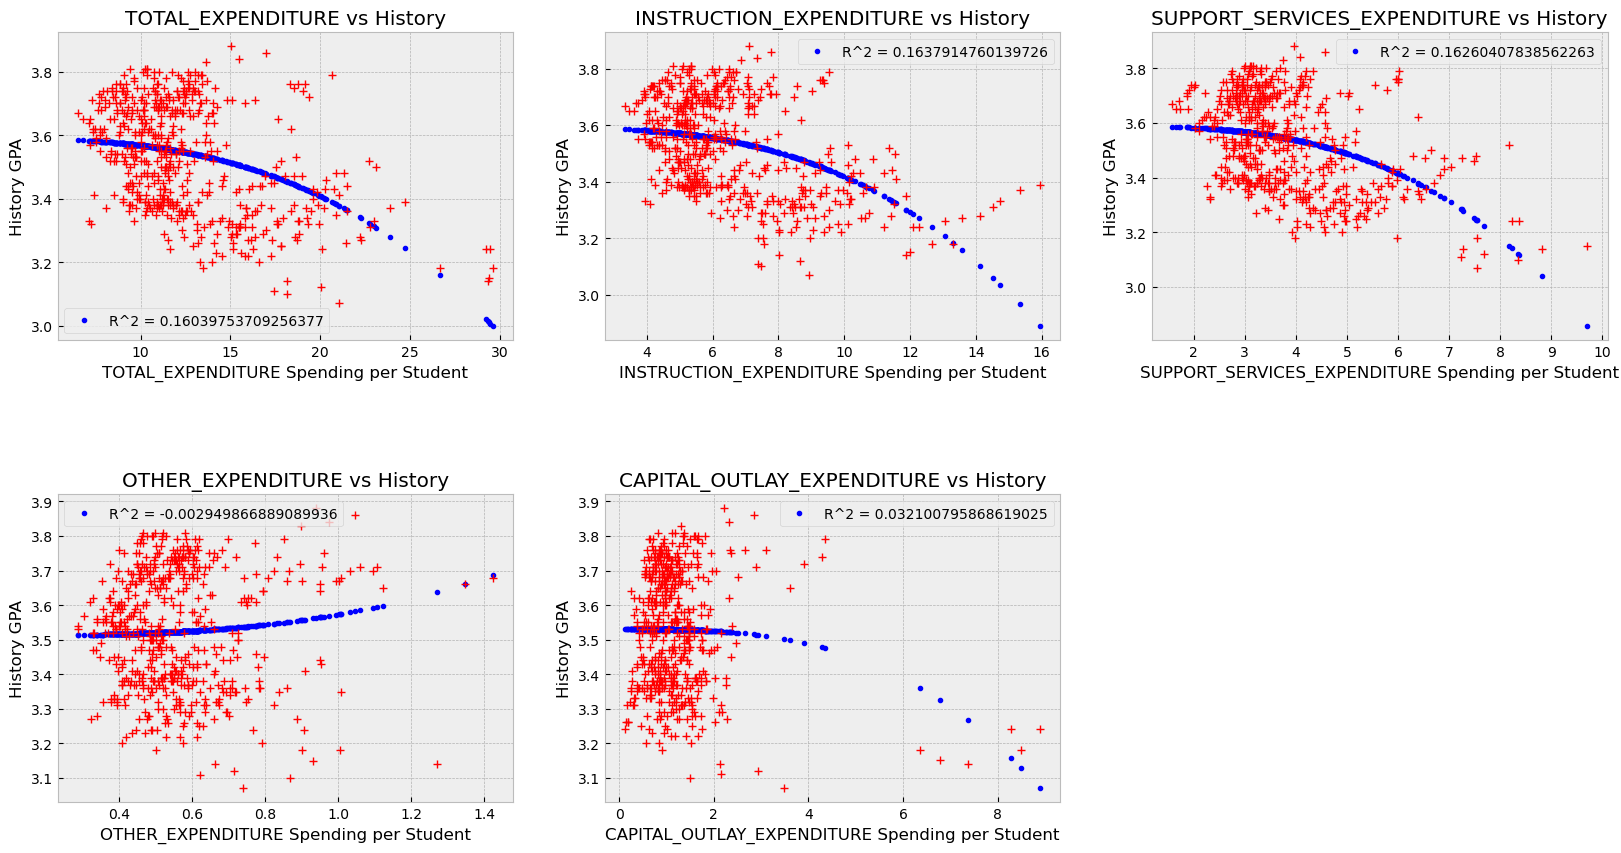

In [58]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)
for i in range(1, len(ind_x)+1):
    plt.subplot(2, 3, i)
    plt.title(f"{names[i-1]} vs History")
    plt.ylabel("History GPA")
    plt.xlabel(f"{names[i-1]} Spending per Student")
    plt.plot(ind_x[i-1], model2.fit(ind_x[i-1], hist).predict(ind_x[i-1]), 'b.')
    plt.plot(ind_x[i-1], hist, 'r+')
    plt.legend([f"R^2 = {sk.metrics.r2_score(hist, model2.fit(ind_x[i-1], hist).predict(ind_x[i-1]) )}"])

Since we have two different models, neither of which Have a high R^2 score, we should at least test their RMSE scores
to see which is better:

In [62]:
for i in range(1, len(ind_x)+1):
    yhat = model.fit(ind_x[i-1], math).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"RBF {names[i-1]} math RMSE: {RMSE}")
print('\n')

for i in range(1, len(ind_x)+1):
    yhat = model2.fit(ind_x[i-1], math).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"POLY {names[i-1]} math RMSE: {RMSE}")


RBF TOTAL_EXPENDITURE math RMSE: 0.1958792191982331
RBF INSTRUCTION_EXPENDITURE math RMSE: 0.19604381955542013
RBF SUPPORT_SERVICES_EXPENDITURE math RMSE: 0.19637085176927443
RBF OTHER_EXPENDITURE math RMSE: 0.20500293390040494
RBF CAPITAL_OUTLAY_EXPENDITURE math RMSE: 0.2020329021151882


POLY TOTAL_EXPENDITURE math RMSE: 0.20208356033563935
POLY INSTRUCTION_EXPENDITURE math RMSE: 0.20055795191087658
POLY SUPPORT_SERVICES_EXPENDITURE math RMSE: 0.2006089431882763
POLY OTHER_EXPENDITURE math RMSE: 0.21134763966826461
POLY CAPITAL_OUTLAY_EXPENDITURE math RMSE: 0.2110373777555691


In [63]:
for i in range(1, len(ind_x)+1):
    yhat = model.fit(ind_x[i-1], eng).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"RBF {names[i-1]} english RMSE: {RMSE}")
print('\n')

for i in range(1, len(ind_x)+1):
    yhat = model2.fit(ind_x[i-1], eng).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"POLY {names[i-1]} english RMSE: {RMSE}")


RBF TOTAL_EXPENDITURE english RMSE: 0.28066789340487225
RBF INSTRUCTION_EXPENDITURE english RMSE: 0.27445066638328364
RBF SUPPORT_SERVICES_EXPENDITURE english RMSE: 0.27630407068814195
RBF OTHER_EXPENDITURE english RMSE: 0.285392764166612
RBF CAPITAL_OUTLAY_EXPENDITURE english RMSE: 0.28024139573855306


POLY TOTAL_EXPENDITURE english RMSE: 0.2802067805820686
POLY INSTRUCTION_EXPENDITURE english RMSE: 0.2772826030705315
POLY SUPPORT_SERVICES_EXPENDITURE english RMSE: 0.2759824666533949
POLY OTHER_EXPENDITURE english RMSE: 0.290158726171385
POLY CAPITAL_OUTLAY_EXPENDITURE english RMSE: 0.28718871967097953


In [64]:
for i in range(1, len(ind_x)+1):
    yhat = model.fit(ind_x[i-1], sci).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"RBF {names[i-1]} science RMSE: {RMSE}")
print('\n')

for i in range(1, len(ind_x)+1):
    yhat = model2.fit(ind_x[i-1], sci).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"POLY {names[i-1]} science RMSE: {RMSE}")


RBF TOTAL_EXPENDITURE science RMSE: 0.22330472586016767
RBF INSTRUCTION_EXPENDITURE science RMSE: 0.22383814056899173
RBF SUPPORT_SERVICES_EXPENDITURE science RMSE: 0.22408948754298555
RBF OTHER_EXPENDITURE science RMSE: 0.2337424030502864
RBF CAPITAL_OUTLAY_EXPENDITURE science RMSE: 0.22868656689227332


POLY TOTAL_EXPENDITURE science RMSE: 0.22964462762102372
POLY INSTRUCTION_EXPENDITURE science RMSE: 0.22834237633169344
POLY SUPPORT_SERVICES_EXPENDITURE science RMSE: 0.2272534240629692
POLY OTHER_EXPENDITURE science RMSE: 0.23544406086252234
POLY CAPITAL_OUTLAY_EXPENDITURE science RMSE: 0.23449854439943948


In [65]:
for i in range(1, len(ind_x)+1):
    yhat = model.fit(ind_x[i-1], hist).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"RBF {names[i-1]} history RMSE: {RMSE}")
print('\n')

for i in range(1, len(ind_x)+1):
    yhat = model2.fit(ind_x[i-1], hist).predict(ind_x[i-1])
    diff = math - yhat

    MSE = (diff ** 2).sum() / len(ind_x[i-1])
    RMSE = (MSE)**.5
    print(f"POLY {names[i-1]} history RMSE: {RMSE}")


RBF TOTAL_EXPENDITURE history RMSE: 0.29231284961136317
RBF INSTRUCTION_EXPENDITURE history RMSE: 0.29236189292037723
RBF SUPPORT_SERVICES_EXPENDITURE history RMSE: 0.2901698318822367
RBF OTHER_EXPENDITURE history RMSE: 0.30007246780794167
RBF CAPITAL_OUTLAY_EXPENDITURE history RMSE: 0.2960496617679454


POLY TOTAL_EXPENDITURE history RMSE: 0.2964852156527442
POLY INSTRUCTION_EXPENDITURE history RMSE: 0.2943819550011869
POLY SUPPORT_SERVICES_EXPENDITURE history RMSE: 0.29420149629996317
POLY OTHER_EXPENDITURE history RMSE: 0.2996782813487364
POLY CAPITAL_OUTLAY_EXPENDITURE history RMSE: 0.29896061342962177


As we can see above there are some interesting things that are occuring between the two models. As was visible when we were graphing the raw data, for the most part, as the spending in the various sections increase, the GPA tends to go down. This trend is not followed for the OTHER_EXPENDITURE because as the spending increases, so does the GPA. When we compare the two Models RMSE scores, overall the RBF one is better than the poly one, but again the R^2 is still very low and that means that the model is does not fit the data all that well.  As such we are going to pass the data into a PCA to try and produce a better rbf model.

In [50]:
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)
print(pca.explained_variance_ratio_)

pca_x0 = []
pca_x1 = []

for item in X_pca:
    
    pca_x0.append([item[0]])
    pca_x1.append([item[1]])


[0.94679785 0.03653785]


As we can see above, the first PCA component explains around 95% of the variance of the score, so we are going to use that component for our graphing. 

In [52]:
model3 = svm.SVR(kernel = 'rbf')

RMSE 0.19529096315913438


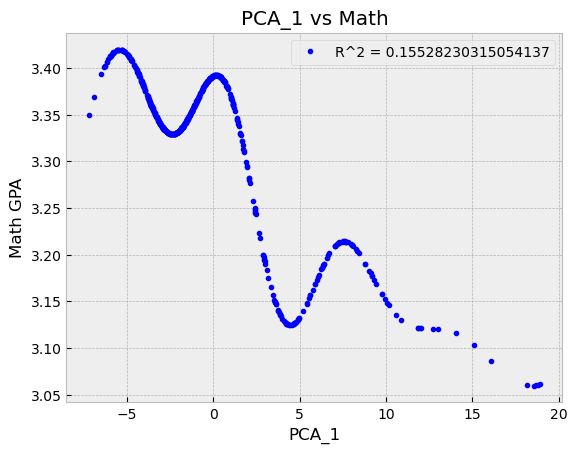

In [54]:
plt.title("PCA_1 vs Math")
plt.xlabel("PCA_1")
plt.ylabel("Math GPA")
plt.plot(pca_x0, model3.fit(pca_x0, math).predict(pca_x0), 'b.')
plt.legend([f"R^2 = {sk.metrics.r2_score(math, model3.fit(pca_x0, math).predict(pca_x0) )}"])

yhat = model3.fit(pca_x0, math).predict(pca_x0)
diff = math - yhat

MSE = (diff ** 2).sum() / len(ind_x[i-1])
RMSE = (MSE)**.5
print(f"RMSE {RMSE}")

As we can see above, this model is not that great either for the reason that the R^2 score is also very low and so the model does not really fit the data all that well. Based on all of this, I think it is safe to say that while funding plays a role in determining how well a student learns, it is not the most important component.